In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from env import PredatorPreyTask
from utils import plot_episode

C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [10]:
class CommNetPP:

    def __init__(self, sess, N, grid_size, embedding_size=50, lr=1e-3, alpha=0.06, memory = True):
        '''
        
        Build CommNet with GRU module
        
        - N: total number of agents
        - J: number of levers (and agents randomly selected at each step)
        - embedding_size: dimension of the hidden layers 
        - lr: learning rate 
        - grid_size: size of the grid
        - alpha: paramater used by reinforce training mode to balance reward and baseline loss
        - memory:
            --> if True: communicate h0(t-1)
            --> if False: communicate h0(t)

        '''

        self.N = N
        self.embedding_size = embedding_size
        self.n_movement_actions = 5  # Stay, North, South, East, West
        self.grid_size = grid_size
        self.memory = memory

        self.build_controler()

        self.alpha = alpha
        self.build_reinforce()
        with tf.variable_scope('Reinforce_optimizer'):
            self.train_op = tf.train.RMSPropOptimizer(
                lr).minimize(self.reinforce_loss)

        self.sess = sess
        self.sess.run(tf.global_variables_initializer())

    def encode(self, inputs):

        agent_positions = inputs[0]
        prey_positions = inputs[1]

        # agent_positions: int in ]0,grid_size^2], position on flatten grid
        # prey_positions: int in [0, grid_size^2], 0 if agent does not see the prey, prey position on flatten grid otherwise

        with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):

            # embedding of agents position and prey positions with 2 different lookup tables
            self.agent_position_embedding = tf.get_variable("agent_position_embedding",
                                                            [self.grid_size**2 + 1, self.embedding_size])  # 0 not used
            self.embedded_agent_position = tf.nn.embedding_lookup(
                self.agent_position_embedding, agent_positions)

            self.prey_position_embedding = tf.get_variable("prey_position_embedding",
                                                           [self.grid_size**2 + 1, self.embedding_size])  # 0 --> cannot see the prey
            self.embedded_prey_position = tf.nn.embedding_lookup(
                self.prey_position_embedding, prey_positions)

        h0 = tf.concat([self.embedded_agent_position,
                        self.embedded_prey_position], axis=2)
        h0_seq = tf.unstack(h0, axis=1)

        return h0_seq

    def build_f(self, name, h, c, cell_state):

        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):

            rnn_cell = tf.nn.rnn_cell.GRUCell(2 * self.embedding_size)

            # add sequence lenght dimension: [batch_size, embedding_dimension] --> [batch_size, 1, embedding_dimension]
            concat = tf.expand_dims(tf.concat([h, c], axis=1), 1)

            output, last_states = tf.nn.dynamic_rnn(
                inputs=concat, cell=rnn_cell, initial_state=cell_state)

            # remove sequence lenght dimension: [batch_size, 1, embedding_dimension] --> [batch_size, embedding_dimension]
            output = tf.squeeze(output, axis=1)
            return output, last_states

    def decode_movement(self, h):

        with tf.variable_scope('Decoder_movement', reuse=tf.AUTO_REUSE):

            W = tf.get_variable('W', shape=(2 * self.embedding_size,
                                            self.n_movement_actions))

            b = tf.get_variable('b', shape=(1, self.n_movement_actions))

            policy_logit = tf.einsum("ij,jk->ik", h, W) + b

            return policy_logit

    def decode_communication(self, h):

        # output size = 2 --> "communicate" or "don't communicate" actions
        with tf.variable_scope('Decoder_communication', reuse=tf.AUTO_REUSE):

            W = tf.get_variable('W', shape=(2 * self.embedding_size,
                                            2))

            b = tf.get_variable('b', shape=(1, 2))

            policy_logit = tf.einsum("ij,jk->ik", h, W) + b

            return policy_logit

    def communicate(self, h_seq, is_communicating):

        # mean of hidden layers of communicating agents except the current one

        return tf.add_n(h_seq) / tf.maximum(1., tf.reduce_sum(self.communication_mask, axis=1, keepdims=True) - is_communicating)

    def sample_actions(self, log_proba):

        action = tf.multinomial(log_proba, num_samples=1)

        return action

    def build_controler(self):

        # communication_mask_values
        self.inputs = tf.placeholder(tf.int32, shape=(None, 2, self.N))
        self.communication_mask = tf.placeholder(
            tf.float32, shape=(None, self.N))
        unstacked_communication_mask = [tf.reshape(
            m, [-1, 1]) for m in tf.unstack(self.communication_mask, axis=1)]

        # hidden layer state values
        self.cell_state = tf.placeholder(
            tf.float32, shape=(None, 2 * self.embedding_size, self.N))
        unstacked_cell_state = tf.unstack(self.cell_state, axis=2)
        
        self.mems = tf.placeholder(tf.int32, shape=(None, 2, self.N))
        h0_mem_seq = self.encode(tf.unstack(self.mems, axis=1))

        h0_seq = self.encode(tf.unstack(self.inputs, axis=1))
        
        if self.memory:
            # communicate h0(t-1)
            c_seq = [self.communicate([h0_mem_seq[j]* unstacked_communication_mask[j] for j in range(
                self.N) if j != i], unstacked_communication_mask[i]) for i in range(self.N)]
        else:
            # communicate h0
            c_seq = [self.communicate([h0_seq[j]* unstacked_communication_mask[j] for j in range(
                self.N) if j != i], unstacked_communication_mask[i]) for i in range(self.N)]

        rnn_modules = [self.build_f(
            "Comm_step_rnn", h0_seq[j], c_seq[j], unstacked_cell_state[j]) for j in range(self.N)]
        # output of rnns
        self.h_seq = [x[0] for x in rnn_modules]
        
        # new cell state of rnns
        self.new_cell_state_seq = tf.stack([x[1] for x in rnn_modules], axis=2)
        
        # can be used to check values of hidden states 
        self.layers = {'h0_seq': h0_seq, 'c_seq': c_seq, 'h_seq': self.h_seq}
        
        # logits of movement actions and communication actions policies
        self.movement_policy_logit_seq = [
            self.decode_movement(h) for h in self.h_seq]
        self.communication_policy_logit_seq = [
            self.decode_communication(h) for h in self.h_seq]
        
        self.movement_log_proba_seq = [tf.nn.log_softmax(
            policy_logit, axis=1) for policy_logit in self.movement_policy_logit_seq]
        self.communication_log_proba_seq = [tf.nn.log_softmax(
            policy_logit, axis=1) for policy_logit in self.communication_policy_logit_seq]

        self.movement_action_seq = [self.sample_actions(
            log_proba) for log_proba in self.movement_log_proba_seq]
        self.communication_action_seq = [self.sample_actions(
            log_proba) for log_proba in self.communication_log_proba_seq]

    def build_baseline(self, h):

        with tf.variable_scope('Baseline', reuse=tf.AUTO_REUSE):

            W = tf.get_variable('W', shape=(2 * self.embedding_size,
                                            1))

            b = tf.get_variable('b', shape=(1,))

            baseline = tf.einsum("ij,jk->ik", h, W) + b

            return baseline

    def build_reinforce(self):
        
        # baseline tensors
        self.baselines = tf.concat([self.build_baseline(h) for h in self.h_seq], axis=1)

        # reward values
        self.reward_values = tf.placeholder(tf.float32, shape=(None, self.N))
        self.reward_values_cumsum = tf.cumsum(
            self.reward_values, axis=0, reverse=True)
        
        # baseline values
        self.baseline_values = tf.placeholder(tf.float32, shape=(None, self.N))

        # movement actions that have been taken
        self.movement_action_taken = tf.placeholder(
            tf.int32, shape=(None, self.N))
        unstacked_movement_action_taken = tf.unstack(
            self.movement_action_taken, axis=1)
        
        # neg log proba of taken movement actions
        self.movement_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_movement_action_taken[j],
                                                                                                          logits=self.movement_policy_logit_seq[j])] for j in range(self.N)], axis=0))
        # communication actions that have been taken
        self.communication_action_taken = tf.placeholder(
            tf.int32, shape=(None, self.N))
        unstacked_communication_action_taken = tf.unstack(
            self.communication_action_taken, axis=1)
        
        # neg log proba of taken communication actions
        self.communication_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_communication_action_taken[j],
                                                                                                               logits=self.communication_policy_logit_seq[j])] for j in range(self.N)], axis=0))
        
        self.neg_log_p = self.movement_neg_log_p + self.communication_neg_log_p
        
        # surrogate loss (- dtheta)
        self.reinforce_loss = tf.reduce_sum(tf.multiply(self.neg_log_p, self.reward_values_cumsum - self.baseline_values))
        self.reinforce_loss += self.alpha * tf.reduce_sum(tf.square(self.reward_values_cumsum - self.baselines))
        self.reinforce_loss /= self.N

    def take_action(self, state, communication_mask, cell_state, mem = None):

        movement_action_seq, communication_action_seq, baselines, new_state_cell_seq = self.sess.run([self.movement_action_seq,
                                                                                                          self.communication_action_seq,
                                                                                                          self.baselines,
                                                                                                          self.new_cell_state_seq],
                                                                                                         {self.inputs: [state],
                                                                                                          self.mems: [mem],
                                                                                                          self.communication_mask: [communication_mask],
                                                                                                          self.cell_state: [cell_state]})
        return np.squeeze(movement_action_seq, axis=(1, 2)), np.squeeze(communication_action_seq, axis=(1, 2)),  baselines, np.squeeze(new_state_cell_seq, axis=(0,))

    def policy_rollout(self, T, env):
        
        state_seq = [np.zeros((2, self.N))]
        movement_action_seq = []
        communication_action_seq = [np.zeros(self.N)]
        cell_state_seq = [np.zeros((2 * self.embedding_size, self.N))]
        reward_seq = []
        baseline_seq = []


        state, terminal_state = env.reset()
        while terminal_state:
            state, terminal_state = env.reset()

        t = 0

        while not terminal_state and t < T:
            t +=1

            movement_action, communication_action, baseline, new_cell_state = self.take_action(state, communication_action_seq[-1], cell_state_seq[-1], state_seq[-1])
            cell_state_seq.append(new_cell_state)
            state_seq.append(state)

            state, reward, terminal_state = env.step(movement_action, communication_action)

            movement_action_seq.append(movement_action)
            communication_action_seq.append(communication_action)
            reward_seq.append(reward)
            baseline_seq.append(baseline)

        rollout = dict()
        rollout['state_seq'] = np.array(state_seq)
        rollout['movement_action_seq'] = np.array(movement_action_seq)
        rollout['communication_action_seq'] = np.array(communication_action_seq)
        rollout['reward_seq'] = np.array(reward_seq)
        rollout['baseline_seq'] = np.squeeze(np.array(baseline_seq), axis = (1,))
        rollout['terminal_state'] = terminal_state
        rollout['cell_state_seq'] = cell_state_seq

        return rollout
        
    
    def reinforce_train(self, env, n_episodes, T):

        history = {'reward': [],  'loss': [], 'terminal_state': []}
        
        
        pbar = tqdm_notebook(total=n_episodes)
        for i in range(n_episodes):

            rollout = self.policy_rollout(T, env)

            episode_len = rollout['reward_seq'].shape[0]

            history['reward'].append(
                np.sum(np.mean(rollout['reward_seq'], axis=1)))
            history['terminal_state'].append(rollout['terminal_state'])

            feed_dict = {}
            feed_dict[self.inputs] = rollout['state_seq'][1:]
            feed_dict[self.mems] = rollout['state_seq'][:-1]
            feed_dict[self.cell_state] = rollout['cell_state_seq'][:-1]
            feed_dict[self.communication_mask] = rollout['communication_action_seq'][:-1]
            feed_dict[self.reward_values] = rollout['reward_seq']
            feed_dict[self.baseline_values] = rollout['baseline_seq']
            feed_dict[self.movement_action_taken] = rollout['movement_action_seq']
            feed_dict[self.communication_action_taken] = rollout['communication_action_seq'][1:]

            _, loss = self.sess.run(
                [self.train_op, self.reinforce_loss], feed_dict=feed_dict)

            history['loss'].append(loss)
            
            if i % 10 == 0:
                pbar.set_description("t. state: {}".format(np.mean(history["terminal_state"][-10:])))
            pbar.update()

        return history

In [20]:
def get_stats(n, T, env, agent):
    
    
    catch_sum = 0
    avg_communication_sum = 0
    episode_lenght_sum = 0
    avg_comm_vision_sum = 0
    avg_comm_non_vision_sum = 0
    avg_vision_sum = 0
    
    
    for _ in tqdm_notebook(range(n), 'Computing stats'):
        
        rollout = agent.policy_rollout(T, env)
        catch_sum += rollout['terminal_state']
        avg_communication_sum += np.mean(rollout['communication_action_seq'])
        
        
        vision_seq = np.squeeze(rollout['state_seq'][1:,1:], axis = 1)
        
        vision_mask = vision_seq > 0
        avg_vision_sum += np.mean(vision_mask)
        
        if np.sum(vision_mask):
            vision_idx = np.where(vision_mask)
            avg_comm_vision_sum += np.mean(rollout['communication_action_seq'][1:][vision_idx])
        else:
            avg_comm_vision_sum += 0
        
        non_vision_mask = vision_seq == 0
        if np.sum(non_vision_mask):
            non_vision_idx = np.where(non_vision_mask)
            avg_comm_non_vision_sum += np.mean(rollout['communication_action_seq'][1:][non_vision_idx])
        else:
            avg_comm_non_vision_sum += 0
        
        episode_lenght_sum += rollout['reward_seq'].shape[0]
        
    
    print("Avg catches: %0.3f" % (catch_sum/n))
    print('Avg episode lenght: %0.3f' % (episode_lenght_sum/n))
    print('Avg number of agent seeing the prey %0.3f' % (avg_vision_sum/n))
    print("Avg communication: %0.3f" % (avg_communication_sum/n))
    print("Avg communication decision when prey seen: %0.3f" % (avg_comm_vision_sum/n))
    print("Avg communication decision when prey not seen: %0.3f" % (avg_comm_non_vision_sum/n))
    

Sess closed


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

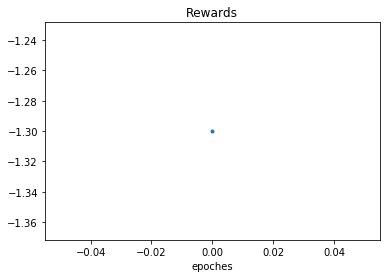

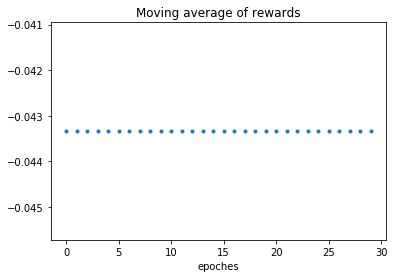

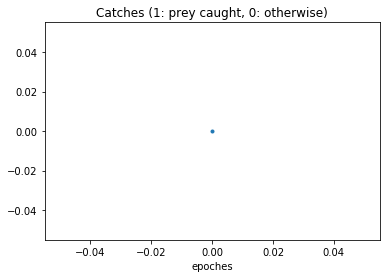

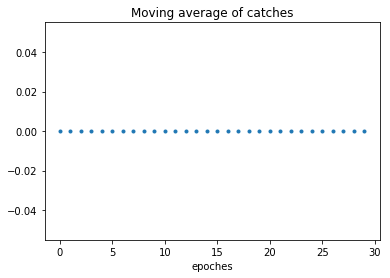

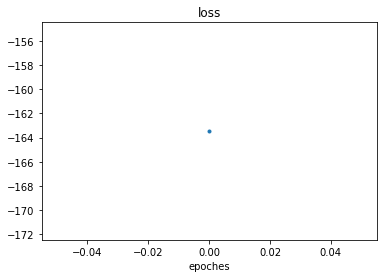

HBox(children=(IntProgress(value=0, description='Computing stats', style=ProgressStyle(description_width='initial')), HTML(value='')))

Avg catches: 0.170
Avg episode lenght: 26.000
Avg number of agent seeing the prey 0.434
Avg communication: 0.445
Avg communication decision when prey seen: 0.443
Avg communication decision when prey not seen: 0.449


In [22]:
N = 3
grid_size = 5
T = 30
n_episodes = 1

if "sess" in locals():
    sess.close()
    print("Sess closed")
tf.reset_default_graph()
sess = tf.Session()

commNet = CommNetPP(sess, N,  grid_size, lr=1e-3, alpha=0.06, memory = True)
env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=3, communication_cost=0.00, step_cost=0.01, forbidden_cost=0.,
                       prey_detection_range=1, uncatched_cost=1., T=T, restart_range = 5)
history = commNet.reinforce_train(env, n_episodes=n_episodes, T=T)

W = 30

plt.title("Rewards")
plt.plot(history['reward'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of rewards")
plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()

plt.title("Catches (1: prey caught, 0: otherwise)")
plt.plot(history['terminal_state'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of catches")
plt.plot(np.convolve(history['terminal_state'],
                     np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()    

plt.title("loss")
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()

get_stats(100, T, env, commNet)


Catched: False


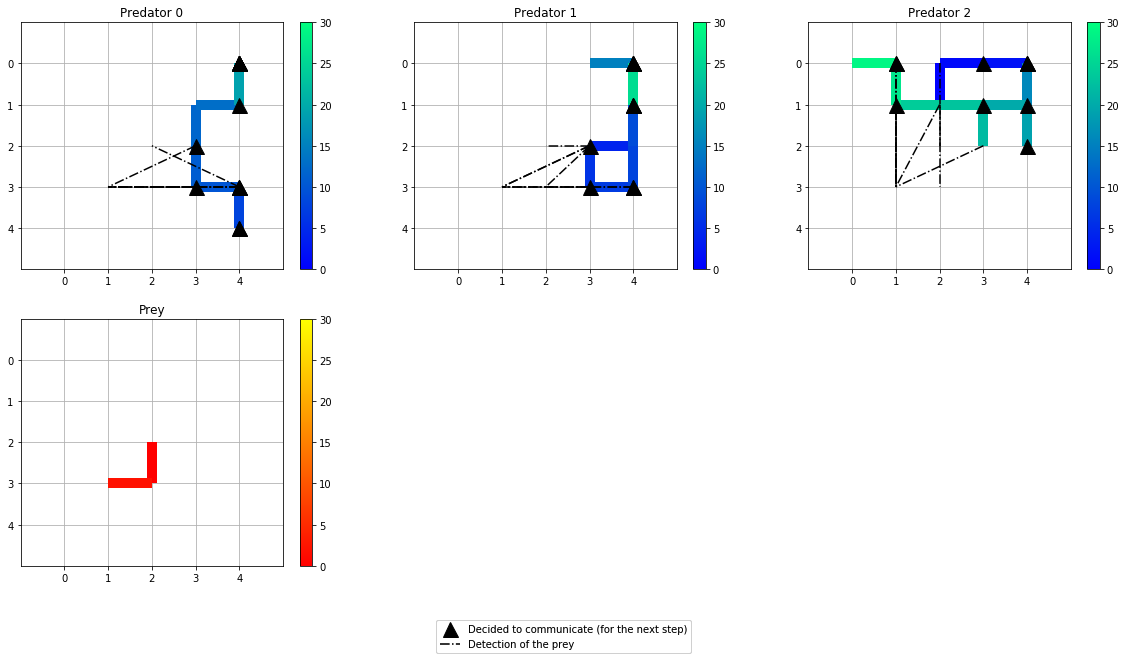

In [27]:
rollout = commNet.policy_rollout(T, env)

print("\nCatched: %s" % bool(rollout['terminal_state']))

pred_coord_history = np.array(env.pred_coord_history)
prey_coord_history = np.array(env.prey_coord_history)
comm_action_history = np.array(env.comm_action_history)
vision_history = np.array(env.vision_history)
plot_episode(pred_coord_history, prey_coord_history,
             comm_action_history, vision_history, grid_size)

# Working parameter sets

### Step cost to low, learn well but take a lot of time to catch the prey

In [ ]:
N = 3
grid_size = 5
T = 100
n_episodes = 1000
if sess:
    sess.close()
tf.reset_default_graph()
sess = tf.Session()

commNet = CommNetPP(sess, N,  grid_size, lr=1e-3,
                    rnn_controler=True, alpha=0.06)
env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=2, communication_cost=0.00, step_cost=0.02, forbidden_cost=0.03,
                       prey_detection_range=2, uncatched_cost=1., T=T, restart_range = 5)
history = commNet.reinforce_train(env, n_episodes=n_episodes, T=T)

W = 30

plt.title("Rewards")
plt.plot(history['reward'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of rewards")
plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()

plt.title("Catches (1: prey caught, 0: otherwise)")
plt.plot(history['terminal_state'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of catches")
plt.plot(np.convolve(history['terminal_state'],
                     np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()    

plt.title("loss")
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()

get_stats(100, T, env, commNet)

HBox(children=(IntProgress(value=0, description='REINFORCE', max=1000, style=ProgressStyle(description_width='initial')), HTML(value='')))

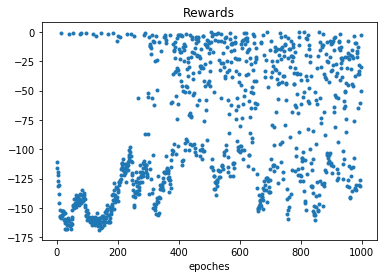

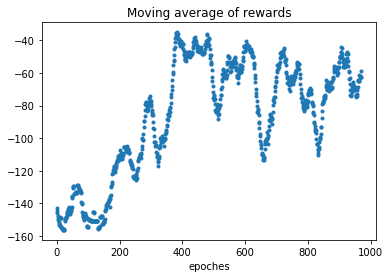

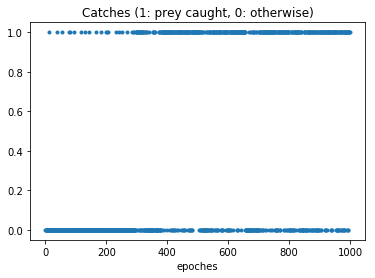

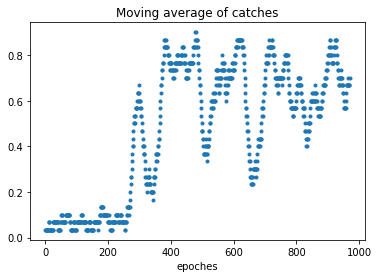

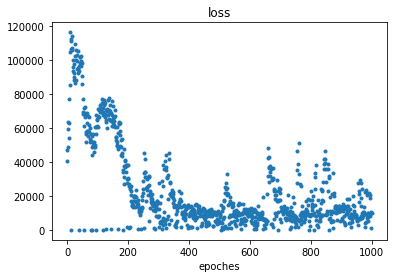

New policy rollout ? (y/n)y

Catched: True


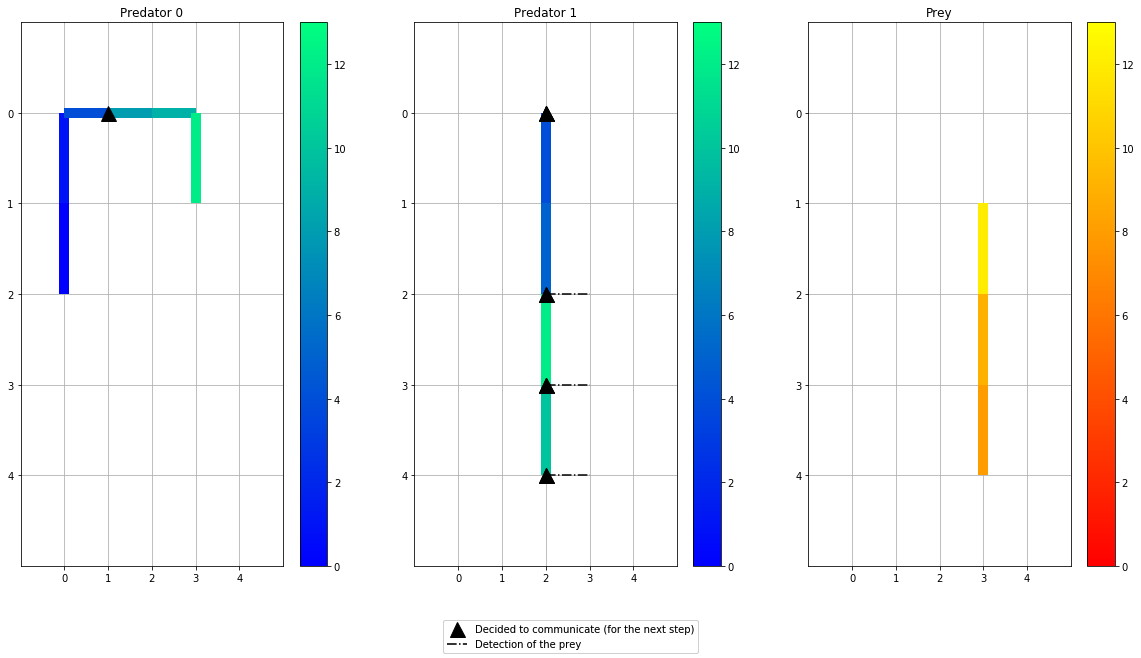

New policy rollout ? (y/n)y

Catched: True


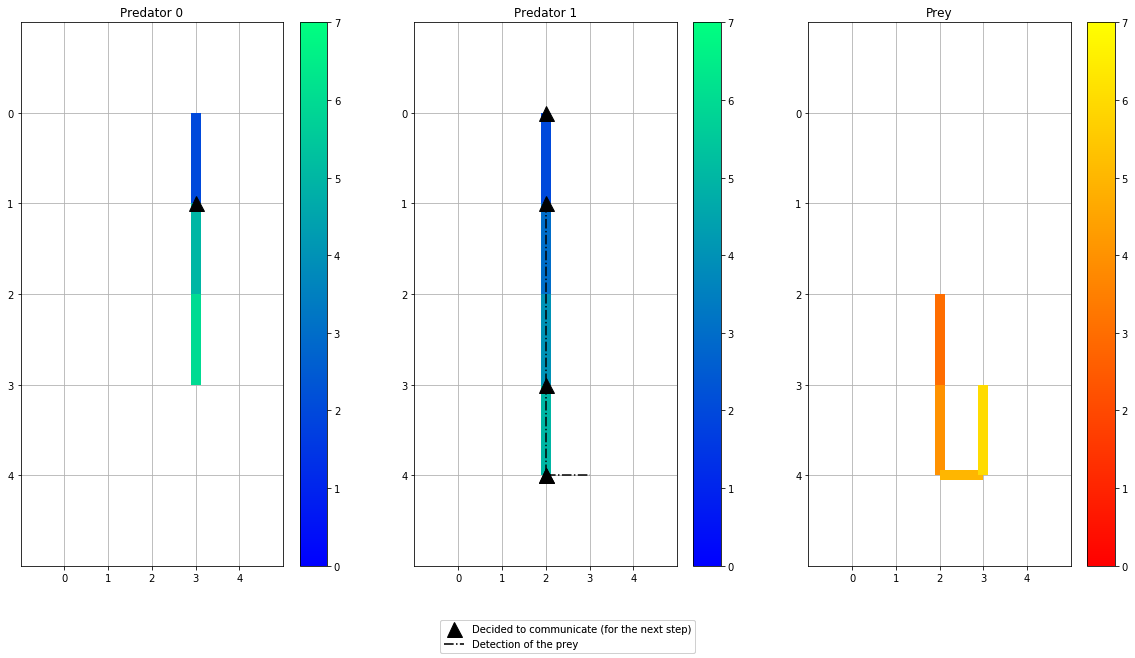

New policy rollout ? (y/n)y

Catched: False


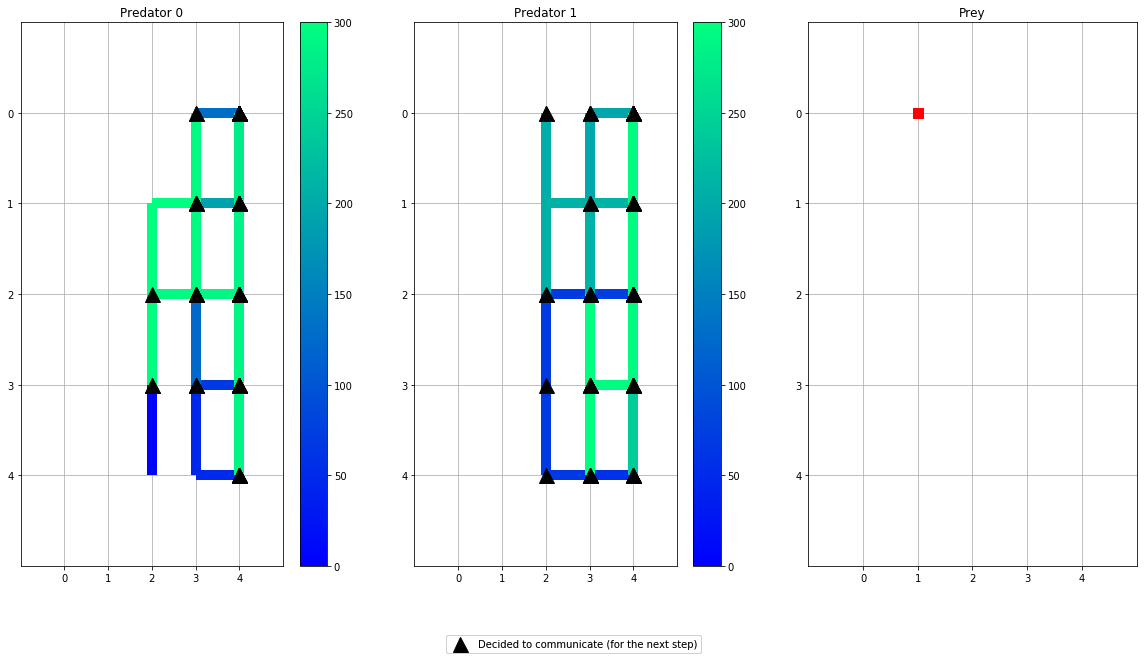

New policy rollout ? (y/n)y

Catched: True


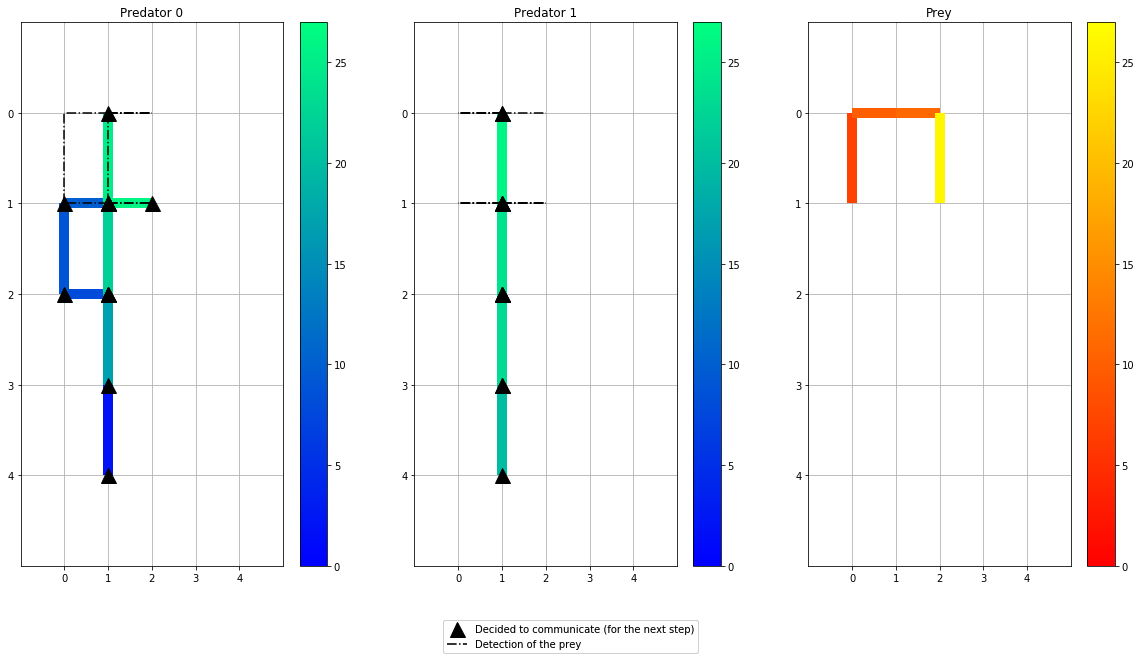

New policy rollout ? (y/n)y

Catched: True


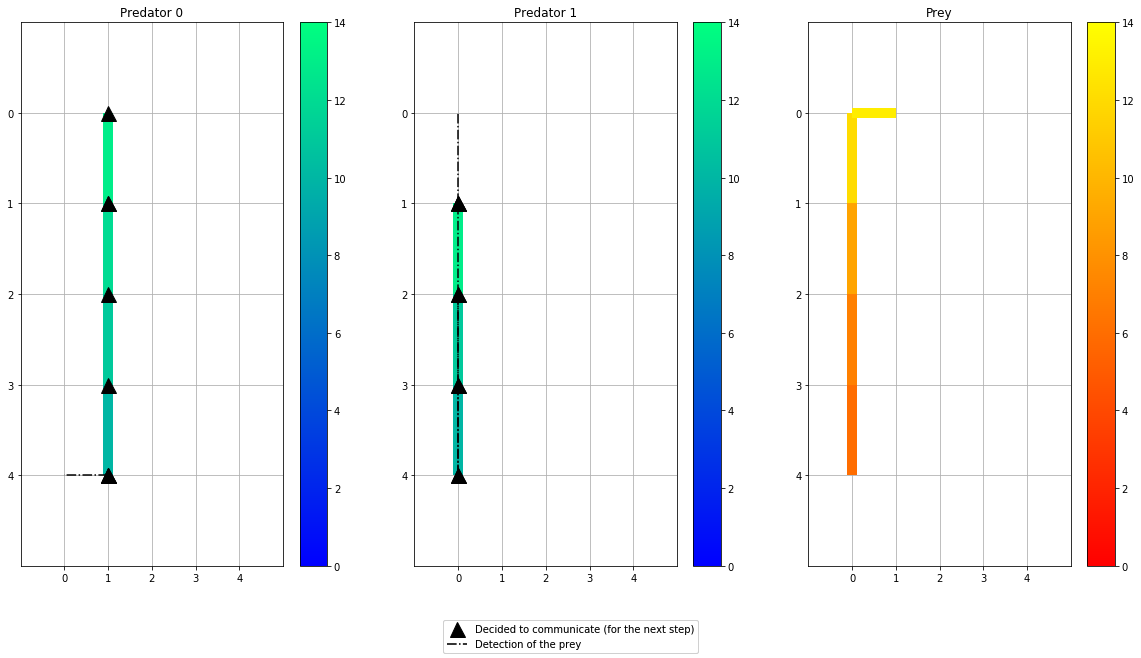

New policy rollout ? (y/n)y

Catched: True


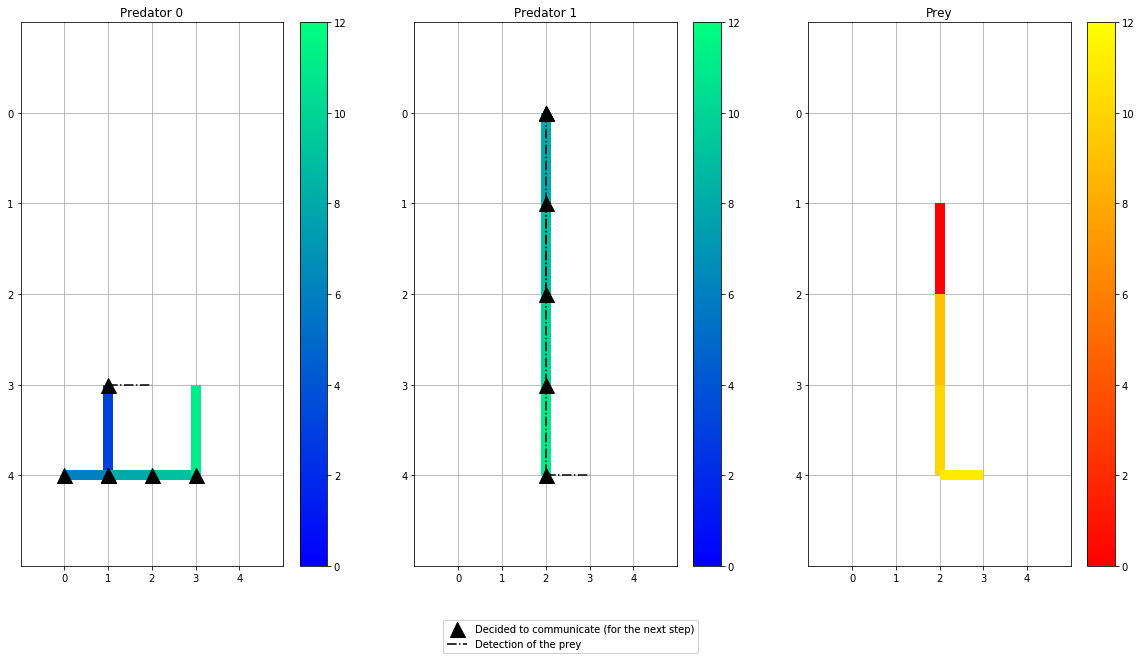

New policy rollout ? (y/n)y

Catched: True


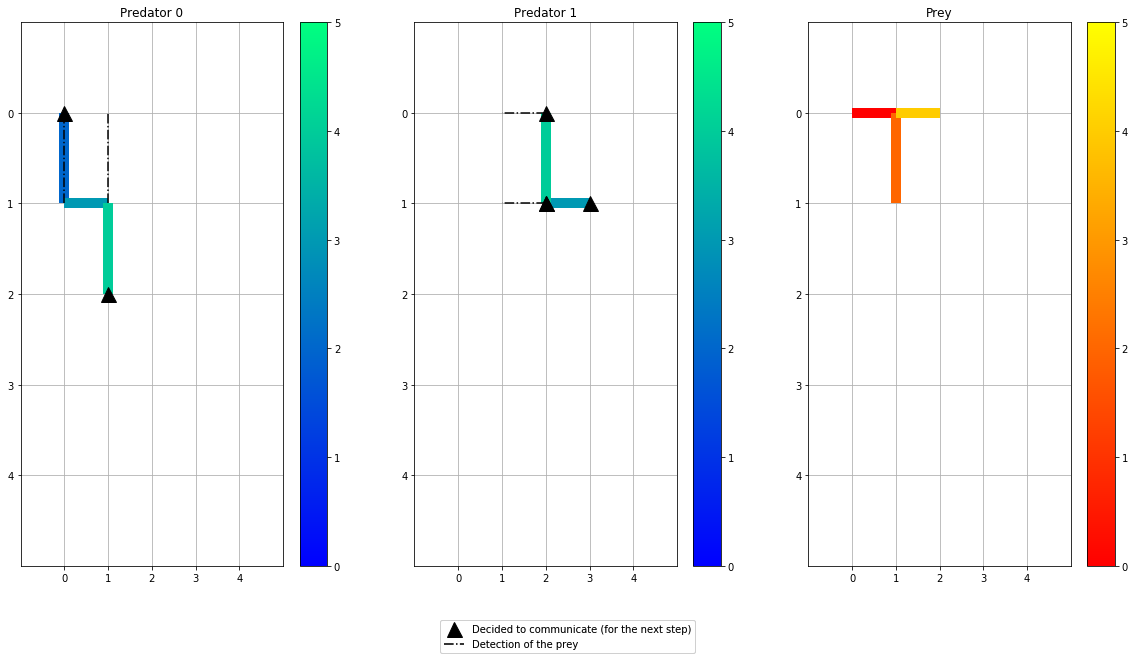

New policy rollout ? (y/n)n


In [15]:
N = 2
grid_size = 5
T = 100
n_episodes = 1000
if sess:
    sess.close()
tf.reset_default_graph()
sess = tf.Session()

commNet = CommNetPP(sess, N,  grid_size, lr=1e-3,
                    rnn_controler=True, alpha=0.06)
env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=2, communication_cost=0.01, step_cost=0.02, forbidden_cost=0.03,
                       prey_detection_range=2, uncatched_cost=1., T=T, restart_range = 5)
history = commNet.reinforce_train(env, n_episodes=n_episodes, T=T)

W = 30

plt.title("Rewards")
plt.plot(history['reward'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of rewards")
plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()

plt.title("Catches (1: prey caught, 0: otherwise)")
plt.plot(history['terminal_state'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of catches")
plt.plot(np.convolve(history['terminal_state'],
                     np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()    

plt.title("loss")
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()